In [188]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [189]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score

In [190]:
test_list_file = "test_files_alex.csv"

In [191]:
def get_basenames(name_list):  # "base name" here means the name without the path and extension
    return [os.path.splitext(os.path.basename(name))[0] for name in name_list]

In [192]:
n = 2
ngram_results = pd.read_csv(f"{n}grams_results/{n}grams_pred_proba.csv", names=["SampleName", "ngram prediction"]).drop_duplicates(subset="SampleName")
files = get_basenames(ngram_results["SampleName"])
ngram_results["SampleName"] = pd.Series(files)
ngram_results.head()


,SampleName,ngram prediction
0,1196707913,3.598928e-03
1,1381388866,4.753447e-08
2,1394Info,1.405845e-12
3,64BitMAPIBroker,4.082133e-07
4,7z,1.542922e-09


In [193]:
cg_results = pd.read_csv("pred_proba/cg_test_output.csv", names=["SampleName", "cg prediction"]).drop_duplicates(subset="SampleName")
cg_results.head()

,SampleName,cg prediction
0,libmwlapack,0.000923
1,TextInputFramework,0.001689
2,VirusShare_7f519098a4a2316f1692de6427bc6404,0.914762
3,VirusShare_cf53ae643e44659ca6b7960916cb16d5,0.999946
4,VirusShare_fa0d674a38ea1e2935a1d080411a4b2f,0.996621


In [194]:
pe_results = pd.read_csv("pred_proba/XGBoost_confidence_results.csv")
pe_results.head()

,SampleName,Malware_confidence (1=malware)
0,BackgroundActivatorDLL.dll,0.000095
1,BamSettingsClient.dll,0.000015
2,BdeSysprep.dll,0.000004
3,BFE.DLL,0.000008
4,BHQFlash.dll,0.001514


In [195]:
#pe_results.pop("IsMalware(1=T)")
#pe_results.pop("Benign_confidence")
pe_results.rename(columns={"Malware_confidence (1=malware)": "pe prediction"}, inplace=True)
files = get_basenames(pe_results["SampleName"])
pe_results["SampleName"] = pd.Series(files)
pe_results.head()

,SampleName,pe prediction
0,BackgroundActivatorDLL,0.000095
1,BamSettingsClient,0.000015
2,BdeSysprep,0.000004
3,BFE,0.000008
4,BHQFlash,0.001514


In [196]:
with open(test_list_file) as f:
    test_files = get_basenames(f.read().splitlines())

In [197]:
set_pred_cg = set(cg_results["SampleName"])
set_test = set(test_files)
print("cg")
print(len(set_pred_cg), len(set_test))
print(len(set_pred_cg & set_test))
print(set_test - set_pred_cg)

set_pred_pe = set(pe_results["SampleName"])
print("\npe")
print(len(pe_results["SampleName"]))
print(len(set_pred_pe), len(set_test))
print(len(set_pred_pe & set_test))

cg
11387 11388
11387
{'test_files_alex'}

pe
11068
11035 11388
11035


In [198]:
input_data = ngram_results.merge(cg_results, on="SampleName").merge(pe_results, on="SampleName")
input_data["Class"] = [1 if sample_name.split("_")[0]=="VirusShare" else 0 for sample_name in input_data["SampleName"]]

In [199]:
input_data.head()

,SampleName,ngram prediction,cg prediction,pe prediction,Class
0,1196707913,3.598928e-03,0.000236,0.006268,0
1,1381388866,4.753447e-08,0.000270,0.005096,0
2,1394Info,1.405845e-12,0.004098,0.000004,0
3,64BitMAPIBroker,4.082133e-07,0.193465,0.000060,0
4,7z,1.542922e-09,0.967001,0.005956,0


In [200]:
print("Total:", len(input_data))
print("Benign:", len(input_data[input_data["Class"]==0]))
print("Malware:", len(input_data[input_data["Class"]==1]))

Total: 9376
Benign: 2579
Malware: 6797


In [201]:
X = input_data.drop('SampleName', axis='columns').drop('Class', axis='columns')
y = input_data["Class"]
samples_names = input_data["SampleName"]

In [202]:
X_train, X_test, y_train, y_test, names_train, names_test = train_test_split(X, y, samples_names, test_size=0.2, random_state=42)

desicion tree
Accuracy: 0.9840085287846482
Precision: 0.9869470630891951
Recall: 0.9912600145666424

boosted decision tree
Accuracy: 0.988272921108742
Precision: 0.9891383055756698
Recall: 0.9949016751638747

neural network
Accuracy: 0.9893390191897654
Precision: 0.990572878897752
Recall: 0.9949016751638747



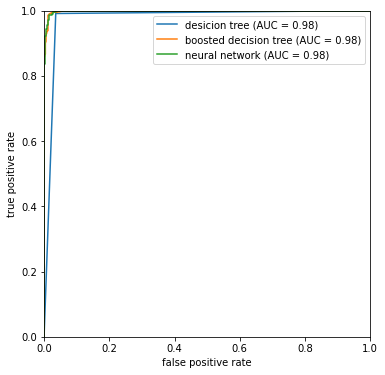

In [203]:
classifier_names = ['desicion tree', 'boosted decision tree', 'neural network']
classifiers = [DecisionTreeClassifier(),
               GradientBoostingClassifier(),
               MLPClassifier()]

plt.figure(figsize=(6,6))
for clf, name in zip(classifiers, classifier_names):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    score_acc = accuracy_score(y_test, y_pred)
    score_prec = precision_score(y_test, y_pred)
    score_rec = recall_score(y_test, y_pred)
    score_auc = roc_auc_score(y_test, y_pred)

    print(name)
    print("Accuracy:", score_acc)
    print("Precision:", score_prec)
    print("Recall:", score_rec)
    print("")

    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test.to_numpy(), y_pred_proba)

    with open("results_ensemble/roc_"+str(name)+".txt", "w") as f:
        f.write("fpr1:\n")
        f.write(str(fpr))
        f.write("\n")
        f.write("tpr1:\n")
        f.write(str(tpr))
        f.write("\n")
    plt.plot(fpr, tpr, label=f"{name} (AUC = {score_auc:.2f})")

plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.axis("scaled")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend()
plt.savefig("results_ensemble/roc.pdf")
plt.savefig("results_ensemble/roc.svg")
plt.savefig("results_ensemble/roc.png")

In [204]:
param_grid_ = {'hidden_layer_sizes': [100, 4, (4, 4), 3, 5, (5, 5), 2, (2, 2), (3, 2)],  # (3, 3) sometimes chosen as best but has terrible ROC curve
                'learning_rate': ["constant", "invscaling"]}

kfold = KFold(n_splits=5, random_state=42, shuffle=True)

clf_base = MLPClassifier(random_state=42, max_iter=500)

grid_search = GridSearchCV(estimator=clf_base,
                            cv=kfold,
                            param_grid=param_grid_,
                            n_jobs=8,  # jobs to run in parallel
                            verbose=1,
                            scoring="balanced_accuracy")

grid_search.fit(X_train, y_train)
clf = grid_search.best_estimator_

# how does it decide which one is best?
print("Best estimator:")
print(clf)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best estimator:
MLPClassifier(hidden_layer_sizes=(4, 4), max_iter=500, random_state=42)


In [205]:
clf1 = MLPClassifier(hidden_layer_sizes=(4, 4), max_iter=500, random_state=42)
clf1.fit(X_train, y_train)

#clf2 = MLPClassifier(hidden_layer_sizes=(2, 2), max_iter=500, random_state=42)
#clf2 = MLPClassifier(hidden_layer_sizes=100, max_iter=500, random_state=42)
#clf2 = MLPClassifier(hidden_layer_sizes=3, max_iter=500, random_state=42)
#clf2 = MLPClassifier(hidden_layer_sizes=5, max_iter=500, random_state=42)
clf2 = MLPClassifier(hidden_layer_sizes=(3, 3), max_iter=500, random_state=42)
clf2.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(3, 3), max_iter=500, random_state=42)

ensemble neural network
Accuracy: 0.9893390191897654
Precision: 0.990572878897752
Recall: 0.9949016751638747

n-grams
Accuracy: 0.9637526652452025
Precision: 0.9644128113879004
Recall: 0.9868900218499636

call graphs
Accuracy: 0.9546908315565032
Precision: 0.9613180515759312
Recall: 0.9774217042971595

PE headers
Accuracy: 0.9722814498933902
Precision: 0.9918093819806404
Recall: 0.9701383831026948



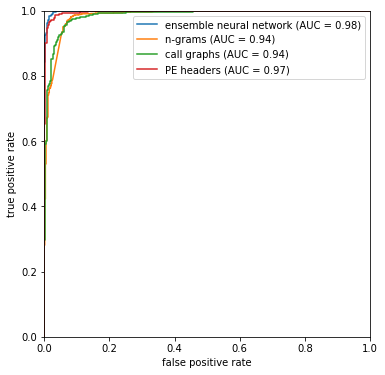

In [206]:
models = ["ensemble neural network",
          #"ensemble neural network (3, 3)",
          "n-grams", "call graphs",
          "PE headers"]

y_preds = [clf1.predict(X_test),
           #clf2.predict(X_test),
           [0 if pred_proba<0.5 else 1 for pred_proba in X_test["ngram prediction"]],
           [0 if pred_proba<0.5 else 1 for pred_proba in X_test["cg prediction"]],
           [0 if pred_proba<0.5 else 1 for pred_proba in X_test["pe prediction"]]]

y_pred_probs = [clf1.predict_proba(X_test)[:, 1],
                #clf2.predict_proba(X_test)[:, 1],
                X_test["ngram prediction"],
                X_test["cg prediction"],
                X_test["pe prediction"]]
fprs = []
tprs = []
scores_auc = []
plt.figure(figsize=(6,6))
for y_pred, y_pred_proba, name in zip(y_preds, y_pred_probs, models):
    score_acc = accuracy_score(y_test, y_pred)
    score_prec = precision_score(y_test, y_pred)
    score_rec = recall_score(y_test, y_pred)
    score_auc = roc_auc_score(y_test, y_pred)

    print(name)
    print("Accuracy:", score_acc)
    print("Precision:", score_prec)
    print("Recall:", score_rec)
    print("")

    fpr, tpr, thresholds = roc_curve(y_test.to_numpy(), y_pred_proba)

    with open("results_final/roc_"+str(name)+".txt", "w") as f:
        f.write("fpr:\n")
        f.write(str(fpr))
        f.write("\n")
        f.write("tpr:\n")
        f.write(str(tpr))
        f.write("\n")
    plt.plot(fpr, tpr, label=f"{name} (AUC = {score_auc:.2f})")
    fprs.append(fpr)
    tprs.append(tpr)
    scores_auc.append(score_auc)

plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.axis("scaled")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend()
plt.savefig("results_final/roc.pdf")
plt.savefig("results_final/roc.svg")
plt.savefig("results_final/roc.png")

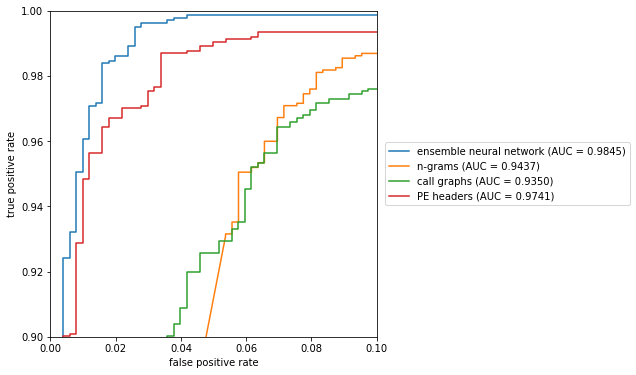

In [207]:
plt.figure(figsize=(6,6))
for fpr, tpr, model, score_auc in zip(fprs, tprs, models, scores_auc):
    plt.plot(fpr, tpr, label=f"{model} (AUC = {score_auc:.4f})")
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.axis("scaled")
plt.xlim([0, 0.1])
plt.ylim([0.9, 1])
plt.legend(bbox_to_anchor=(1.01,0.5), loc="center left")
plt.savefig("results_final/roc_zoom.pdf", bbox_inches='tight')
plt.savefig("results_final/roc_zoom.svg", bbox_inches='tight')
plt.savefig("results_final/roc_zoom.png", bbox_inches='tight')